In [24]:
import rasterio
from rasterio.crs import CRS
import geopandas as gpd
from shapely.geometry import box
import matplotlib.pyplot as plt
from tqdm import tqdm
from boto3.s3.transfer import TransferConfig

# Generate tiles

We are going to use the Hansen et al. data found [here](https://storage.googleapis.com/earthenginepartners-hansen/GFC-2020-v1.8/download.html). For actual products, this would likely be Planet data or some high resolution map that we would need for classification.

In [2]:
# box inputs are minx, miny, maxx, maxy
geometries = [box(-180 + i * 10, 
                  80 - (j + 1) * 10, 
                  -180 + (i + 1) * 10,
                  80 - (j) * 10) for i in range(36) for j in range(16)]

# Upper left corner
ul_corners = [(-180 + (i) * 10, 80 - (j) * 10) for i in range(36) for j in range(16)]
df_hansen_tiles = gpd.GeoDataFrame(geometry=geometries, crs=CRS.from_epsg(4326))

Let's see the tiles.

<AxesSubplot:>

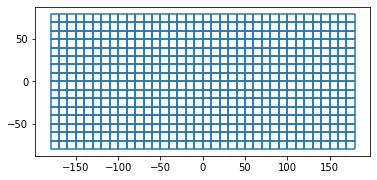

In [3]:
df_hansen_tiles.exterior.plot()

In [4]:
def url_generator(corner: tuple, 
                  layer: str ='last'):
    
    assert(layer in ['first', 'last', 'treecover2000'])
    
    base_url = 'https://storage.googleapis.com/earthenginepartners-hansen/GFC-2020-v1.8'
    lon, lat = corner
    if lon < 0:
        lon_str = f'{abs(lon):03d}W'
    else:
        lon_str = f'{abs(lon):03d}E'
    if lat >= 0:
        lat_str = f'{abs(lat):02d}N'
    else:
        lat_str = f'{abs(lat):02d}S'
    return f'{base_url}/Hansen_GFC-2020-v1.8_last_{lat_str}_{lon_str}.tif'


In [5]:
df_hansen_tiles['source_url'] = list(map(url_generator, ul_corners))
df_hansen_tiles['year'] = 2020
df_hansen_tiles['bucket'] = 'test-calval-hansen-mosaics-2020'
df_hansen_tiles['key'] = df_hansen_tiles.source_url.map(lambda x: x.split('/')[-1])

df_hansen_tiles.head()

,geometry,source_url,year,bucket,key
0,"POLYGON ((-170.00000 70.00000, -170.00000 80.0...",https://storage.googleapis.com/earthenginepart...,2020,test-calval-hansen-mosaics-2020,Hansen_GFC-2020-v1.8_last_80N_180W.tif
1,"POLYGON ((-170.00000 60.00000, -170.00000 70.0...",https://storage.googleapis.com/earthenginepart...,2020,test-calval-hansen-mosaics-2020,Hansen_GFC-2020-v1.8_last_70N_180W.tif
2,"POLYGON ((-170.00000 50.00000, -170.00000 60.0...",https://storage.googleapis.com/earthenginepart...,2020,test-calval-hansen-mosaics-2020,Hansen_GFC-2020-v1.8_last_60N_180W.tif
3,"POLYGON ((-170.00000 40.00000, -170.00000 50.0...",https://storage.googleapis.com/earthenginepart...,2020,test-calval-hansen-mosaics-2020,Hansen_GFC-2020-v1.8_last_50N_180W.tif
4,"POLYGON ((-170.00000 30.00000, -170.00000 40.0...",https://storage.googleapis.com/earthenginepart...,2020,test-calval-hansen-mosaics-2020,Hansen_GFC-2020-v1.8_last_40N_180W.tif


Let's read the bounds from the URLs and make sure they match.

In [6]:
url = df_hansen_tiles.source_url[0]
with rasterio.open(url) as ds:
    print(ds.bounds)
    print(url)

BoundingBox(left=-180.0001388888889, bottom=69.9998611111111, right=-169.99986111111113, top=80.00013888888888)
https://storage.googleapis.com/earthenginepartners-hansen/GFC-2020-v1.8/Hansen_GFC-2020-v1.8_last_80N_180W.tif


# Get Tiles over AOIs

In [7]:
aois = gpd.read_file('aois.geojson')
aois_geo = aois.geometry.unary_union

<AxesSubplot:>

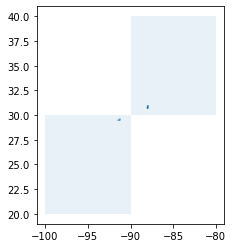

In [8]:
fig, ax = plt.subplots()

df_hansen_deltas = df_hansen_tiles[df_hansen_tiles.geometry.intersects(aois_geo)].reset_index(drop=True)

df_hansen_deltas.plot(ax = ax, alpha=.1)
aois.plot(ax=ax)

In [9]:
df_hansen_deltas

,geometry,source_url,year,bucket,key
0,"POLYGON ((-90.00000 20.00000, -90.00000 30.000...",https://storage.googleapis.com/earthenginepart...,2020,test-calval-hansen-mosaics-2020,Hansen_GFC-2020-v1.8_last_30N_100W.tif
1,"POLYGON ((-80.00000 30.00000, -80.00000 40.000...",https://storage.googleapis.com/earthenginepart...,2020,test-calval-hansen-mosaics-2020,Hansen_GFC-2020-v1.8_last_40N_090W.tif


In [10]:
df_hansen_deltas.source_url.tolist()

['https://storage.googleapis.com/earthenginepartners-hansen/GFC-2020-v1.8/Hansen_GFC-2020-v1.8_last_30N_100W.tif',
 'https://storage.googleapis.com/earthenginepartners-hansen/GFC-2020-v1.8/Hansen_GFC-2020-v1.8_last_40N_090W.tif']

# Upload Tile Index to s3

References from Stackoverflow:
+ [How to connect to s3](https://stackoverflow.com/a/40336919) - there are two ways
+ [Upload json to s3](https://stackoverflow.com/a/53004085)

In [11]:
geojson_bytes = bytes(df_hansen_deltas.to_json(drop_id=True).encode('UTF-8'))
geojson_bytes

b'{"type": "FeatureCollection", "features": [{"type": "Feature", "properties": {"bucket": "test-calval-hansen-mosaics-2020", "key": "Hansen_GFC-2020-v1.8_last_30N_100W.tif", "source_url": "https://storage.googleapis.com/earthenginepartners-hansen/GFC-2020-v1.8/Hansen_GFC-2020-v1.8_last_30N_100W.tif", "year": 2020}, "geometry": {"type": "Polygon", "coordinates": [[[-90.0, 20.0], [-90.0, 30.0], [-100.0, 30.0], [-100.0, 20.0], [-90.0, 20.0]]]}}, {"type": "Feature", "properties": {"bucket": "test-calval-hansen-mosaics-2020", "key": "Hansen_GFC-2020-v1.8_last_40N_090W.tif", "source_url": "https://storage.googleapis.com/earthenginepartners-hansen/GFC-2020-v1.8/Hansen_GFC-2020-v1.8_last_40N_090W.tif", "year": 2020}, "geometry": {"type": "Polygon", "coordinates": [[[-80.0, 30.0], [-80.0, 40.0], [-90.0, 40.0], [-90.0, 30.0], [-80.0, 30.0]]]}}]}'

In [12]:
import boto3

session = boto3.session.Session(profile_name='saml-pub')

s3 = session.resource('s3')
s3object = s3.Object('calval-metadata', 'test-hansen-landsat-sim.geojson')
s3object.put(Body=geojson_bytes)

{'ResponseMetadata': {'RequestId': 'VAHNYW8Q3FSW09D4',
  'HostId': 'pV6idWfcR+6a4tEhpNlyPt3RLdLNK88HV3YKnxmX5MNgUPTx6M8kMccdI6baPDQgYL/wJ/MyZ5A=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'pV6idWfcR+6a4tEhpNlyPt3RLdLNK88HV3YKnxmX5MNgUPTx6M8kMccdI6baPDQgYL/wJ/MyZ5A=',
   'x-amz-request-id': 'VAHNYW8Q3FSW09D4',
   'date': 'Wed, 22 Dec 2021 00:11:08 GMT',
   'etag': '"52a1e9c4d64a172ee02c47da3bf63dea"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"52a1e9c4d64a172ee02c47da3bf63dea"'}

# Read Geojson on S3

Show existing buckets

In [13]:
buckets = list(s3.buckets.all())

Let's inspect the bucket contents.

In [14]:
metadata_bucket = s3.Bucket('calval-metadata')
list(metadata_bucket.objects.all())

[s3.ObjectSummary(bucket_name='calval-metadata', key='test-hansen-landsat-sim.geojson'),
 s3.ObjectSummary(bucket_name='calval-metadata', key='test-hansen-landsat.geojson')]

Read the actual dataframe.

In [15]:
obj = s3.Object('calval-metadata', 'test-hansen-landsat.geojson')
obj.get()

{'ResponseMetadata': {'RequestId': 'WG8P7427V79X5RES',
  'HostId': 'QWdtPoV3TQg5QIkfTmf32TyXrOhRIu78llQliSIk3GasQ/YrjLkvzyalL/oBcwW2Y4aZGgMPLRk=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'QWdtPoV3TQg5QIkfTmf32TyXrOhRIu78llQliSIk3GasQ/YrjLkvzyalL/oBcwW2Y4aZGgMPLRk=',
   'x-amz-request-id': 'WG8P7427V79X5RES',
   'date': 'Wed, 22 Dec 2021 00:11:10 GMT',
   'last-modified': 'Mon, 20 Dec 2021 19:40:20 GMT',
   'etag': '"52a1e9c4d64a172ee02c47da3bf63dea"',
   'accept-ranges': 'bytes',
   'content-type': 'binary/octet-stream',
   'server': 'AmazonS3',
   'content-length': '845'},
  'RetryAttempts': 0},
 'AcceptRanges': 'bytes',
 'LastModified': datetime.datetime(2021, 12, 20, 19, 40, 20, tzinfo=tzutc()),
 'ContentLength': 845,
 'ETag': '"52a1e9c4d64a172ee02c47da3bf63dea"',
 'ContentType': 'binary/octet-stream',
 'Metadata': {},
 'Body': <botocore.response.StreamingBody at 0x7f086d42ae90>}

In [16]:
data = obj.get()['Body']
gpd.read_file(data)

,bucket,key,source_url,year,geometry
0,test-calval-hansen-mosaics-2020,Hansen_GFC-2020-v1.8_last_30N_100W.tif,https://storage.googleapis.com/earthenginepart...,2020,"POLYGON ((-90.00000 20.00000, -90.00000 30.000..."
1,test-calval-hansen-mosaics-2020,Hansen_GFC-2020-v1.8_last_40N_090W.tif,https://storage.googleapis.com/earthenginepart...,2020,"POLYGON ((-80.00000 30.00000, -80.00000 40.000..."


# Upload to Mosaics to s3 (this takes a *long* time on a local machine)

It's negligible on a fast server.

The buckets have to be unique globally - interesting that this is harder than it seems and will throw an [error](https://stackoverflow.com/q/57146311) like this.

In [17]:
bucket_name = df_hansen_deltas.bucket[0]
if bucket_name not in [b.name for b in buckets]:
    s3.Bucket(bucket_name).create(CreateBucketConfiguration={'LocationConstraint': 'us-west-2'})

In [18]:
records = df_hansen_deltas.to_dict('records')

In [19]:
record = records[0]

In [20]:
import requests

r = requests.get(record['source_url'], stream=True)
total_size = int(r.headers['Content-length'])
print( total_size / 1e9, 'GB')

5.022295203 GB


You need to use boto3 multipart upload; tqdm has a nice way to track upload as well.

Sources: 

1. Basic upload from s3 using public url: [link](https://stackoverflow.com/questions/14346065/upload-image-available-at-public-url-to-s3-using-boto)
2. Upload large file using TransferConfig and boto3: [link](https://stackoverflow.com/a/50118024) 
3. Getting tqdm to work with the above: [link](https://stackoverflow.com/a/70263266)
4. Doc on transferconfig: [link](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/customizations/s3.html#boto3.s3.transfer.TransferConfig)

In [28]:
def upload_one(record):
    
    r = requests.get(record['source_url'], stream=True)
    total_size = int(r.headers['Content-length'])

    bucket_name = record['bucket']
    key = record['key']
    config = TransferConfig(multipart_threshold=1024, 
                            max_concurrency=30,
                            # Commenting this out appears to make upload speed more variable
                            #multipart_chunksize=1024, 
                            use_threads=True)
    with tqdm(total=total_size,  
              unit='B', 
              unit_scale=True, 
              unit_divisor=1024) as pbar:


        bucket = s3.Bucket(bucket_name)
        resp = bucket.upload_fileobj(r.raw, key, Config=config, Callback=pbar.update)
    
    return resp

In [29]:
list(map(upload_one, tqdm(records[:])))

  0%|                                                               | 0/1 [00:00<?, ?it/s]
  0%|                                                         | 0.00/12.3G [00:00<?, ?B/s]
  0%|                                                | 256k/12.3G [00:00<5:57:15, 616kB/s]
  0%|                                               | 512k/12.3G [00:00<3:26:32, 1.07MB/s]
  0%|                                                | 5.75M/12.3G [00:00<14:51, 14.8MB/s]
  0%|                                                | 13.8M/12.3G [00:00<06:38, 33.1MB/s]
  0%|                                                | 14.0M/12.3G [00:00<04:40, 47.0MB/s]
  0%|                                                | 30.0M/12.3G [00:00<02:43, 80.6MB/s]
  0%|▏                                                | 44.5M/12.3G [00:00<01:54, 115MB/s]
  0%|▏                                                | 44.5M/12.3G [00:00<01:54, 115MB/s]
  0%|▏                                                | 60.5M/12.3G [00:01<01:41, 130MB/s]

  7%|███▋                                              | 914M/12.3G [00:09<01:36, 127MB/s]
  7%|███▋                                              | 926M/12.3G [00:09<01:47, 114MB/s]
  7%|███▋                                             | 938M/12.3G [00:10<02:07, 95.7MB/s]
  8%|███▊                                              | 952M/12.3G [00:10<01:54, 107MB/s]
  8%|███▊                                              | 964M/12.3G [00:10<02:01, 100MB/s]
  8%|███▉                                              | 977M/12.3G [00:10<01:51, 109MB/s]
  8%|███▉                                              | 994M/12.3G [00:10<01:27, 140MB/s]
  8%|███▉                                              | 994M/12.3G [00:10<01:27, 140MB/s]
  8%|███▉                                             | 0.99G/12.3G [00:10<01:24, 144MB/s]
  8%|███▉                                             | 1.00G/12.3G [00:10<01:23, 145MB/s]
  8%|███▉                                             | 1.00G/12.3G [00:10<01:23, 145MB/s]

 13%|██████▏                                          | 1.55G/12.3G [00:14<01:09, 166MB/s]
 13%|██████▏                                          | 1.56G/12.3G [00:14<01:19, 145MB/s]
 13%|██████▏                                          | 1.56G/12.3G [00:14<01:26, 133MB/s]
 13%|██████▎                                          | 1.58G/12.3G [00:14<01:15, 153MB/s]
 13%|██████▎                                          | 1.58G/12.3G [00:14<01:15, 153MB/s]
 13%|██████▎                                          | 1.59G/12.3G [00:15<01:14, 155MB/s]
 13%|██████▎                                          | 1.59G/12.3G [00:15<01:13, 156MB/s]
 13%|██████▍                                          | 1.61G/12.3G [00:15<01:24, 137MB/s]
 13%|██████▍                                          | 1.62G/12.3G [00:15<01:30, 127MB/s]
 13%|██████▌                                          | 1.65G/12.3G [00:15<01:11, 161MB/s]
 14%|██████▋                                          | 1.67G/12.3G [00:15<01:07, 169MB/s]

 20%|█████████▉                                       | 2.49G/12.3G [00:20<01:08, 154MB/s]
 20%|█████████▉                                       | 2.49G/12.3G [00:20<01:12, 145MB/s]
 20%|█████████▉                                       | 2.51G/12.3G [00:21<01:06, 159MB/s]
 20%|█████████▉                                       | 2.51G/12.3G [00:21<01:04, 163MB/s]
 20%|█████████▉                                       | 2.51G/12.3G [00:21<01:04, 163MB/s]
 21%|██████████                                       | 2.53G/12.3G [00:21<01:06, 159MB/s]
 21%|██████████                                       | 2.53G/12.3G [00:21<01:07, 154MB/s]
 21%|██████████                                       | 2.54G/12.3G [00:21<01:07, 156MB/s]
 21%|██████████▏                                      | 2.54G/12.3G [00:21<01:07, 156MB/s]
 21%|██████████▏                                      | 2.56G/12.3G [00:21<01:06, 158MB/s]
 21%|██████████▎                                      | 2.57G/12.3G [00:21<01:04, 161MB/s]

 26%|████████████▊                                    | 3.21G/12.3G [00:25<01:06, 146MB/s]
 26%|████████████▊                                    | 3.22G/12.3G [00:25<01:03, 152MB/s]
 26%|████████████▊                                    | 3.22G/12.3G [00:25<01:03, 152MB/s]
 26%|████████████▉                                    | 3.24G/12.3G [00:25<01:02, 155MB/s]
 26%|████████████▉                                    | 3.24G/12.3G [00:25<01:02, 157MB/s]
 26%|████████████▉                                    | 3.25G/12.3G [00:25<01:02, 155MB/s]
 27%|█████████████                                    | 3.27G/12.3G [00:26<00:57, 167MB/s]
 27%|█████████████                                    | 3.27G/12.3G [00:26<00:53, 182MB/s]
 27%|█████████████                                    | 3.27G/12.3G [00:26<00:53, 182MB/s]
 27%|█████████████                                    | 3.29G/12.3G [00:26<00:54, 177MB/s]
 27%|█████████████                                    | 3.29G/12.3G [00:26<00:55, 176MB/s]

 34%|████████████████▍                                | 4.12G/12.3G [00:31<00:56, 157MB/s]
 34%|████████████████▍                                | 4.12G/12.3G [00:31<00:54, 161MB/s]
 34%|████████████████▍                                | 4.12G/12.3G [00:31<00:54, 161MB/s]
 34%|████████████████▍                                | 4.14G/12.3G [00:31<00:52, 166MB/s]
 34%|████████████████▍                                | 4.14G/12.3G [00:31<00:52, 166MB/s]
 34%|████████████████▌                                | 4.16G/12.3G [00:31<00:57, 151MB/s]
 34%|████████████████▌                                | 4.17G/12.3G [00:31<00:54, 159MB/s]
 34%|████████████████▌                                | 4.17G/12.3G [00:31<00:51, 170MB/s]
 34%|████████████████▌                                | 4.17G/12.3G [00:31<00:51, 170MB/s]
 34%|████████████████▋                                | 4.19G/12.3G [00:32<00:53, 163MB/s]
 34%|████████████████▊                                | 4.21G/12.3G [00:32<00:52, 167MB/s]

 41%|████████████████████                             | 5.03G/12.3G [00:38<00:46, 168MB/s]
 41%|████████████████████                             | 5.03G/12.3G [00:38<00:46, 168MB/s]
 41%|████████████████████                             | 5.05G/12.3G [00:38<00:46, 168MB/s]
 41%|████████████████████▏                            | 5.06G/12.3G [00:38<00:47, 162MB/s]
 41%|████████████████████▏                            | 5.07G/12.3G [00:38<00:48, 160MB/s]
 41%|████████████████████▏                            | 5.07G/12.3G [00:38<00:48, 160MB/s]
 41%|████████████████████▏                            | 5.07G/12.3G [00:38<00:48, 160MB/s]
 41%|████████████████████▏                            | 5.08G/12.3G [00:38<00:48, 161MB/s]
 41%|████████████████████▏                            | 5.08G/12.3G [00:38<00:47, 161MB/s]
 41%|████████████████████▏                            | 5.08G/12.3G [00:38<00:47, 161MB/s]
 41%|████████████████████▏                            | 5.08G/12.3G [00:38<00:47, 161MB/s]

 47%|███████████████████████                          | 5.78G/12.3G [00:42<00:40, 175MB/s]
 47%|███████████████████████                          | 5.78G/12.3G [00:42<00:41, 169MB/s]
 47%|███████████████████████                          | 5.79G/12.3G [00:42<00:41, 167MB/s]
 47%|███████████████████████▏                         | 5.81G/12.3G [00:43<00:46, 149MB/s]
 47%|███████████████████████▏                         | 5.81G/12.3G [00:43<00:50, 138MB/s]
 47%|███████████████████████▏                         | 5.83G/12.3G [00:43<00:45, 153MB/s]
 47%|███████████████████████▏                         | 5.83G/12.3G [00:43<00:45, 153MB/s]
 47%|███████████████████████▏                         | 5.83G/12.3G [00:43<00:45, 153MB/s]
 47%|███████████████████████▎                         | 5.84G/12.3G [00:43<00:46, 150MB/s]
 47%|███████████████████████▎                         | 5.84G/12.3G [00:43<00:46, 150MB/s]
 48%|███████████████████████▎                         | 5.86G/12.3G [00:43<00:44, 156MB/s]

 53%|█████████████████████████▊                       | 6.49G/12.3G [00:47<00:35, 177MB/s]
 53%|█████████████████████████▊                       | 6.49G/12.3G [00:47<00:35, 177MB/s]
 53%|█████████████████████████▊                       | 6.49G/12.3G [00:47<00:35, 177MB/s]
 53%|█████████████████████████▉                       | 6.51G/12.3G [00:47<00:35, 174MB/s]
 53%|█████████████████████████▉                       | 6.52G/12.3G [00:47<00:36, 169MB/s]
 53%|██████████████████████████                       | 6.54G/12.3G [00:48<00:36, 171MB/s]
 53%|██████████████████████████                       | 6.54G/12.3G [00:48<00:36, 171MB/s]
 53%|██████████████████████████                       | 6.56G/12.3G [00:48<00:35, 172MB/s]
 53%|██████████████████████████▏                      | 6.57G/12.3G [00:48<00:41, 149MB/s]
 53%|██████████████████████████▏                      | 6.57G/12.3G [00:48<00:47, 129MB/s]
 53%|██████████████████████████▏                      | 6.57G/12.3G [00:48<00:47, 129MB/s]

 58%|████████████████████████████▍                    | 7.13G/12.3G [00:52<00:35, 157MB/s]
 58%|████████████████████████████▍                    | 7.14G/12.3G [00:52<00:36, 152MB/s]
 58%|████████████████████████████▍                    | 7.14G/12.3G [00:52<00:37, 146MB/s]
 58%|████████████████████████████▍                    | 7.14G/12.3G [00:52<00:37, 146MB/s]
 58%|████████████████████████████▌                    | 7.16G/12.3G [00:52<00:37, 148MB/s]
 58%|████████████████████████████▌                    | 7.16G/12.3G [00:52<00:37, 148MB/s]
 58%|████████████████████████████▌                    | 7.17G/12.3G [00:52<00:39, 139MB/s]
 58%|████████████████████████████▌                    | 7.17G/12.3G [00:52<00:41, 131MB/s]
 58%|████████████████████████████▋                    | 7.19G/12.3G [00:52<00:38, 143MB/s]
 58%|████████████████████████████▋                    | 7.19G/12.3G [00:52<00:38, 143MB/s]
 58%|████████████████████████████▋                    | 7.19G/12.3G [00:52<00:38, 143MB/s]

 65%|███████████████████████████████▋                 | 7.95G/12.3G [00:57<00:28, 162MB/s]
 65%|███████████████████████████████▋                 | 7.95G/12.3G [00:57<00:29, 160MB/s]
 65%|███████████████████████████████▋                 | 7.95G/12.3G [00:57<00:29, 160MB/s]
 65%|███████████████████████████████▋                 | 7.96G/12.3G [00:57<00:30, 152MB/s]
 65%|███████████████████████████████▊                 | 7.98G/12.3G [00:57<00:29, 156MB/s]
 65%|███████████████████████████████▊                 | 7.99G/12.3G [00:57<00:29, 159MB/s]
 65%|███████████████████████████████▉                 | 8.01G/12.3G [00:58<00:29, 158MB/s]
 65%|███████████████████████████████▉                 | 8.02G/12.3G [00:58<00:30, 152MB/s]
 65%|███████████████████████████████▉                 | 8.02G/12.3G [00:58<00:30, 150MB/s]
 65%|███████████████████████████████▉                 | 8.02G/12.3G [00:58<00:30, 150MB/s]
 65%|████████████████████████████████                 | 8.04G/12.3G [00:58<00:30, 151MB/s]

 71%|██████████████████████████████████▊              | 8.75G/12.3G [01:02<00:21, 178MB/s]
 71%|██████████████████████████████████▉              | 8.76G/12.3G [01:03<00:21, 175MB/s]
 71%|██████████████████████████████████▉              | 8.78G/12.3G [01:03<00:24, 154MB/s]
 71%|██████████████████████████████████▉              | 8.78G/12.3G [01:03<00:26, 142MB/s]
 71%|███████████████████████████████████              | 8.79G/12.3G [01:03<00:26, 143MB/s]
 71%|███████████████████████████████████              | 8.79G/12.3G [01:03<00:26, 142MB/s]
 71%|███████████████████████████████████              | 8.79G/12.3G [01:03<00:26, 142MB/s]
 72%|███████████████████████████████████              | 8.81G/12.3G [01:03<00:26, 142MB/s]
 72%|███████████████████████████████████              | 8.81G/12.3G [01:03<00:26, 142MB/s]
 72%|███████████████████████████████████▏             | 8.82G/12.3G [01:03<00:24, 151MB/s]
 72%|███████████████████████████████████▏             | 8.84G/12.3G [01:03<00:24, 152MB/s]

 81%|███████████████████████████████████████▌         | 9.95G/12.3G [01:10<00:18, 136MB/s]
 81%|███████████████████████████████████████▋         | 9.97G/12.3G [01:11<00:15, 162MB/s]
 81%|███████████████████████████████████████▊         | 9.98G/12.3G [01:11<00:18, 138MB/s]
 81%|███████████████████████████████████████▊         | 10.0G/12.3G [01:11<00:21, 117MB/s]
 81%|███████████████████████████████████████▉         | 10.0G/12.3G [01:11<00:17, 141MB/s]
 81%|███████████████████████████████████████▉         | 10.0G/12.3G [01:11<00:15, 159MB/s]
 81%|███████████████████████████████████████▉         | 10.0G/12.3G [01:11<00:15, 159MB/s]
 81%|███████████████████████████████████████▉         | 10.0G/12.3G [01:11<00:15, 159MB/s]
 82%|███████████████████████████████████████▉         | 10.0G/12.3G [01:11<00:15, 158MB/s]
 82%|████████████████████████████████████████         | 10.0G/12.3G [01:11<00:15, 160MB/s]
 82%|████████████████████████████████████████         | 10.1G/12.3G [01:11<00:14, 170MB/s]

 90%|███████████████████████████████████████████▉     | 11.0G/12.3G [01:17<00:07, 191MB/s]
 90%|███████████████████████████████████████████▉     | 11.0G/12.3G [01:17<00:07, 191MB/s]
 90%|███████████████████████████████████████████▉     | 11.0G/12.3G [01:17<00:08, 170MB/s]
 90%|███████████████████████████████████████████▉     | 11.0G/12.3G [01:17<00:07, 170MB/s]
 90%|████████████████████████████████████████████     | 11.1G/12.3G [01:17<00:08, 163MB/s]
 90%|████████████████████████████████████████████     | 11.1G/12.3G [01:17<00:08, 158MB/s]
 90%|████████████████████████████████████████████     | 11.1G/12.3G [01:18<00:08, 164MB/s]
 90%|████████████████████████████████████████████▏    | 11.1G/12.3G [01:18<00:07, 166MB/s]
 90%|████████████████████████████████████████████▏    | 11.1G/12.3G [01:18<00:07, 167MB/s]
 90%|████████████████████████████████████████████▏    | 11.1G/12.3G [01:18<00:07, 163MB/s]
 90%|████████████████████████████████████████████▏    | 11.1G/12.3G [01:18<00:07, 163MB/s]

 97%|███████████████████████████████████████████████▎ | 11.9G/12.3G [01:23<00:02, 155MB/s]
 97%|███████████████████████████████████████████████▍ | 11.9G/12.3G [01:23<00:02, 179MB/s]
 97%|███████████████████████████████████████████████▍ | 11.9G/12.3G [01:23<00:02, 175MB/s]
 97%|███████████████████████████████████████████████▌ | 11.9G/12.3G [01:23<00:02, 181MB/s]
 97%|███████████████████████████████████████████████▌ | 11.9G/12.3G [01:23<00:02, 181MB/s]
 97%|███████████████████████████████████████████████▌ | 11.9G/12.3G [01:23<00:02, 181MB/s]
 97%|███████████████████████████████████████████████▌ | 12.0G/12.3G [01:23<00:02, 164MB/s]
 97%|███████████████████████████████████████████████▋ | 12.0G/12.3G [01:23<00:02, 161MB/s]
 97%|███████████████████████████████████████████████▋ | 12.0G/12.3G [01:23<00:02, 164MB/s]
 98%|███████████████████████████████████████████████▊ | 12.0G/12.3G [01:23<00:02, 155MB/s]
 98%|███████████████████████████████████████████████▊ | 12.0G/12.3G [01:23<00:02, 152MB/s]

[None]

# Notes

+ S3 objects can be overwritten without problem. However, buckets cannot. So you cannot create a bucket that already exists, but you can easily overwrite an existing object

# Appendix

I initially used rasterio, but it was much slower. Keeping it here for reference. Probably because the memory file writing was unecessary.

References:

+ [rasterio mem files with a post](https://rasterio.readthedocs.io/en/latest/topics/memory-files.html#reading-memoryfiles)
+ [write s3 using rasterio](https://github.com/rasterio/rasterio/issues/1159#issuecomment-532027616)

In [30]:
from rasterio.io import MemoryFile

def upload_one_slow(record):
    with rasterio.open(record['source_url']) as ds:
        src_profile = ds.profile
        src_array = ds.read()
    with MemoryFile() as memfile:
        with memfile.open(**src_profile) as dataset:
            dataset.write(src_array)

        s3ob = s3.Object(record['bucket'], record['key'])
        s3ob.put(Body=memfile)